# CNN Clustering Analysis (incl. alternative explanations)

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys
sys.path.append('..')

import matplotlib.pylab as plt
import pandas as pd
from tqdm import tqdm
from IPython import display
from multiprocessing import Pool, set_start_method
set_start_method('spawn')

from src.visualization import draw_mlp_clustering_report, run_double_spectral_cluster
from src.utils import get_weights_paths, build_clustering_results
from src.experiment_tagging import get_model_path, MODEL_TAG_LOOKUP
from src.spectral_cluster_model import SHUFFLE_METHODS

/home/arda/.miniconda3/envs/mod/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/arda/.miniconda3/envs/mod/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arda/.miniconda3/envs/mod/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)ty

In [3]:
import itertools
flatten = itertools.chain.from_iterable

model_tags = list(tag for tag in MODEL_TAG_LOOKUP.keys()
              if 'CNN' in tag)
print(model_tags)
mlp_model_paths = {
    model_tag: get_model_path(model_tag, filter_='all', date_tag='202012*')
    for model_tag in model_tags
}
print('\n'.join([f'{k}: {v}' for k, v in mlp_model_paths.items()]))

['CNN:MNIST', 'CNN:CIFAR10', 'CNN:FASHION', 'CNN:MNIST+DROPOUT', 'CNN:CIFAR10+DROPOUT', 'CNN:FASHION+DROPOUT']
CNN:MNIST: [PosixPath('../models/20201202/mnist_cnn_10epochs/194951'), PosixPath('../models/20201202/mnist_cnn_10epochs/195917'), PosixPath('../models/20201202/mnist_cnn_10epochs/200533'), PosixPath('../models/20201202/mnist_cnn_10epochs/201146'), PosixPath('../models/20201202/mnist_cnn_10epochs/201803')]
CNN:CIFAR10: [PosixPath('../models/20201202/cifar10_cnn_10epochs/210035'), PosixPath('../models/20201202/cifar10_cnn_10epochs/210554'), PosixPath('../models/20201202/cifar10_cnn_10epochs/211115'), PosixPath('../models/20201202/cifar10_cnn_10epochs/211636'), PosixPath('../models/20201202/cifar10_cnn_10epochs/212158')]
CNN:FASHION: [PosixPath('../models/20201203/fashion_cnn_10epochs/130547'), PosixPath('../models/20201203/fashion_cnn_10epochs/131207'), PosixPath('../models/20201203/fashion_cnn_10epochs/131826'), PosixPath('../models/20201203/fashion_cnn_10epochs/132450'), Posix

In [4]:
all_clustering_results = []
for tag, paths in mlp_model_paths.items():
    for path in paths:
        all_clustering_results.append(pd.read_csv(path / (tag + ".csv")))

all_clustering_results = pd.concat(all_clustering_results)

In [5]:
all_clustering_results.to_csv('../results/cnn-clustering.csv')
all_clustering_results

,Unnamed: 0,model,network,dropout,is_unpruned,shuffle_method,ncut,ave_in_out,n_samples,mean,stdev,z_score,percentile,train_acc,train_loss,test_acc,test_loss
0,0,MNIST,CNN,False,False,layer,0.486664,3.609615,20,0.330067,0.038194,4.100059,1.000000,0.999950,0.000733,0.9901,0.039492
1,1,MNIST,CNN,False,True,layer,0.236923,7.941561,20,0.248121,0.029232,-0.383071,0.142857,0.998167,0.005213,0.9899,0.043153
2,2,MNIST,CNN,False,False,layer_nonzero,0.486664,3.609615,20,0.497877,0.011551,-0.970811,0.190476,0.999950,0.000733,0.9901,0.039492
3,3,MNIST,CNN,False,True,layer_nonzero,0.236923,7.941561,20,0.248121,0.029232,-0.383071,0.142857,0.998167,0.005213,0.9899,0.043153
4,4,MNIST,CNN,False,False,layer_nonzero_distribution,0.486664,3.609615,20,0.494066,0.014429,-0.513058,0.333333,0.999950,0.000733,0.9901,0.039492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,3,FASHION,CNN,True,True,layer_nonzero,0.491937,3.565560,20,0.218131,0.009073,30.178688,1.000000,0.923300,0.206196,0.9178,0.223540
4,4,FASHION,CNN,True,False,layer_nonzero_distribution,0.291722,6.355849,20,0.298695,0.008107,-0.860117,0.047619,0.853517,0.377123,0.9067,0.264276
5,5,FASHION,CNN,True,True,layer_nonzero_distribution,0.491937,3.565560,20,0.214464,0.006548,42.378203,1.000000,0.923300,0.206196,0.9178,0.223540
6,6,FASHION,CNN,True,False,layer_all_distribution,0.291722,6.355849,20,0.296445,0.024122,-0.195810,0.190476,0.853517,0.377123,0.9067,0.264276


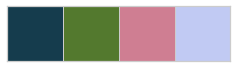

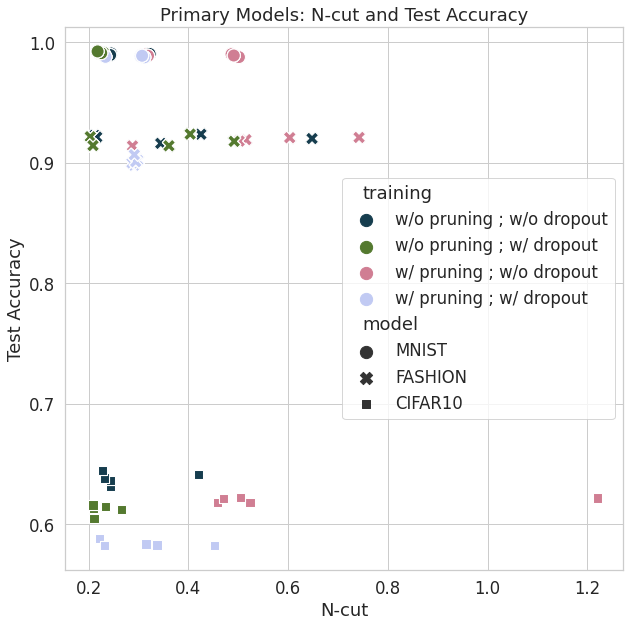

In [6]:
import seaborn as sns
import numpy as np


def training_text(is_pruned, is_dropout):
    pruned_text = "w/" if is_pruned else "w/o"
    dropout_text = "w/" if is_dropout else "w/o"
    return f"{pruned_text} pruning ; {dropout_text} dropout"


PRIMARY_DATASETS = ["MNIST", "FASHION", "CIFAR10"]

primary_models_df = all_clustering_results.copy()
primary_models_df["training"] = 1 * primary_models_df["dropout"].astype(
    int
) + 2 * (~primary_models_df["is_unpruned"]).astype(int)
primary_models_df["training"] = primary_models_df["training"].map(lambda x:[
        "w/o pruning ; w/o dropout",
        "w/o pruning ; w/ dropout",
        "w/ pruning ; w/o dropout",
        "w/ pruning ; w/ dropout",
    ][x])

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# reorder colors to make sure that red-green and blue-orange do not overlap
# refactor that with color names!
# pruning_dropout_palette = sns.color_palette()
# pruning_dropout_palette = pruning_dropout_palette[3], pruning_dropout_palette[2], pruning_dropout_palette[0], pruning_dropout_palette[1]
pruning_dropout_palette = sns.color_palette("cubehelix", 4)

sns.palplot(pruning_dropout_palette)


f, ax = plt.subplots(1, figsize=(10, 10))
g = sns.scatterplot(
    x="ncut",
    y="test_acc",
    style="model",
    hue="training",
    hue_order=[
        "w/o pruning ; w/o dropout",
        "w/o pruning ; w/ dropout",
        "w/ pruning ; w/o dropout",
        "w/ pruning ; w/ dropout",
    ],
    style_order=["MNIST", "FASHION", "CIFAR10"],
    s=170,
    palette=pruning_dropout_palette,
    data=primary_models_df,
    ax=ax,
)

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[1:], labels=labels[1:])

# ax.legend(loc='upper left', bbox_to_anchor= (0.0, -0.2), ncol=2,
#            borderaxespad=0, frameon=False)

for lh in g.legend_.legendHandles:
    lh._sizes = [150]

plt.title('Primary Models: N-cut and Test Accuracy')
plt.xlabel("N-cut")
plt.ylabel("Test Accuracy")
plt.savefig("../plots/scatter-primary-models-cnn.png", dpi=300)